
# 📊 Análisis y Modelado de Locales en Madrid

Proyecto Final de Máster - Data Science  
Autor: [Tu Nombre]  
Fecha: [Fecha Actual]

Este notebook presenta el proceso completo de modelado de datos para la clasificación de locales en Madrid, incluyendo carga de datos, preprocesamiento, entrenamiento del modelo con SMOTE, evaluación y análisis de resultados.

---


In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Configuraciones
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')



## 📥 Carga de Datos

Cargamos el archivo `locales_procesado.csv` con las variables ya preprocesadas.


In [2]:

# Carga del archivo CSV
data = pd.read_csv('../data/locales_procesado.csv')
data.head()


,nombre,direccion,codigo_postal,puntuacion_media,numero_reviews,tipo_negocio,latitud,longitud,categoria_negocio,categoria_id,density_500m,density_1000m,density_2000m,ratio_500m_2km,dist_city_center_km,local_density_1km,cluster_zone,dist_city_center_km^2,dist_city_center_km density_1000m,density_1000m^2,valoracion,puntuacion_std,reviews_std,reviews_bin,valoracion_norm,valoracion_por_cercania
0,Hotel NH Collection Madrid Colón,"Calle del Marqués de Zurgena, 4, Madrid",28001,4.6,1504.0,"lodging, point_of_interest, establishment",40.426076,-3.689070,Alojamiento,1,55,163,682,0.080527,1.618243,163,0,2.618712,263.773683,26569.0,4.6,0.782565,-0.061078,muchos,0.931153,2.677153
1,Rosewood Villa Magna,"Paseo de la Castellana, 22, Madrid",28001,4.5,2670.0,"gym, lodging, spa, health, restaurant, food, p...",40.429952,-3.688152,Restauración,9,45,161,577,0.077855,1.973073,161,0,3.893019,317.664828,25921.0,4.5,0.632361,0.071156,muchos,0.894508,2.170690
2,Hotel Único Madrid,"Calle de Claudio Coello, 67, Madrid",28001,4.7,526.0,"lodging, restaurant, food, point_of_interest, ...",40.428537,-3.686331,Restauración,9,40,174,563,0.070922,1.972295,174,0,3.889947,343.179315,30276.0,4.7,0.932770,-0.171991,muchos,0.950343,2.268017
3,Hotel Fénix Gran Meliá - The Leading Hotels of...,"Calle de Hermosilla, 2, Madrid",28001,4.6,1675.0,"lodging, point_of_interest, establishment",40.426552,-3.689210,Alojamiento,1,54,160,676,0.079764,1.643555,160,0,2.701274,262.968844,25600.0,4.6,0.782565,-0.041685,muchos,0.931153,2.638287
4,H10 Puerta de Alcalá,"Calle Alcalá, 66, Madrid",28001,4.4,2849.0,"lodging, point_of_interest, establishment",40.422182,-3.681154,Alojamiento,1,33,151,540,0.060998,2.008330,151,0,4.033388,303.257779,22801.0,4.4,0.482156,0.091456,muchos,0.862307,2.086960



## 🔎 Exploración de Datos

Visualizamos algunas estadísticas generales y la distribución de la variable objetivo.


In [3]:

# Estadísticas generales
data.describe()

# Distribución de la variable objetivo
data['valoracion'].value_counts()


valoracion
4.300000    237
4.400000    224
4.200000    204
4.500000    191
4.000000    151
           ... 
4.561022      1
3.899976      1
1.459903      1
2.600000      1
3.900000      1
Name: count, Length: 907, dtype: int64


## 🔧 Transformación de la Variable Objetivo

Dado que `valoracion` es continua, la transformamos en categorías para clasificación.


In [4]:

# Crear categorías a partir de la valoración
bins = [0, 3, 4, 5]
labels = ['baja', 'media', 'alta']
data['valoracion_categoria'] = pd.cut(data['valoracion'], bins=bins, labels=labels, include_lowest=True)

# Revisar la distribución
print(data['valoracion_categoria'].value_counts())


valoracion_categoria
alta     1690
media     777
baja      414
Name: count, dtype: int64



## ✂️ División de Datos

Dividimos el conjunto en entrenamiento y prueba de forma estratificada para mantener la proporción de clases.


In [5]:

# Variables predictoras y objetivo
X = data.drop(columns=['valoracion', 'valoracion_categoria'])
y = data['valoracion_categoria']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



## 🔧 Preprocesamiento y Pipeline

Aplicamos escalado a las variables numéricas y one-hot encoding a las categóricas.


In [6]:
# Columnas
numeric_features = ['latitud', 'longitud', 'valoracion_norm', 'density_1000m', 
                    'ratio_500m_2km', 'dist_city_center_km', 
                    'puntuacion_std', 'reviews_std']
categorical_features = ['categoria_negocio']

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Pipeline con SMOTE integrado
pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42))
])


## 🚀 Entrenamiento del Modelo

Entrenamos el modelo Random Forest con el conjunto balanceado.


In [7]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['latitud', 'longitud',
                                                   'valoracion_norm',
                                                   'density_1000m',
                                                   'ratio_500m_2km',
                                                   'dist_city_center_km',
                                                   'puntuacion_std',
                                                   'reviews_std']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['categoria_negocio'])])),
                ('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(max_depth=6, n_estimators=200,
                                        random_state=42))])


## 📈 Evaluación del Modelo

Obtenemos el classification report y la matriz de confusión.


              precision    recall  f1-score   support

        alta       1.00      0.99      1.00       338
        baja       0.99      0.99      0.99        83
       media       0.98      1.00      0.99       156

    accuracy                           0.99       577
   macro avg       0.99      0.99      0.99       577
weighted avg       0.99      0.99      0.99       577



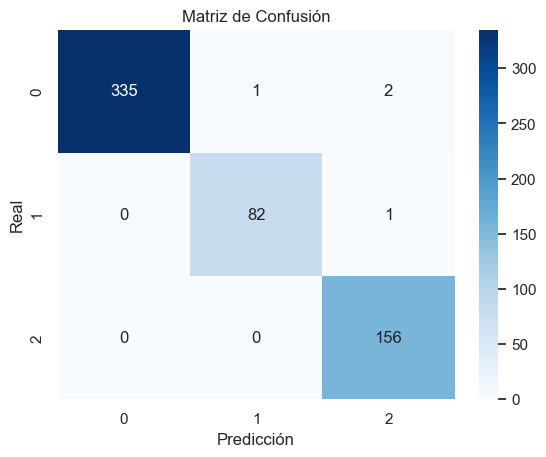

In [8]:

# Predicciones
y_pred = pipeline.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


## 📊 Evaluación del Modelo

Evaluamos el rendimiento del modelo mediante un reporte de clasificación y la matriz de confusión.

Classification Report:

              precision    recall  f1-score   support

        alta       1.00      0.99      1.00       338
        baja       0.99      0.99      0.99        83
       media       0.98      1.00      0.99       156

    accuracy                           0.99       577
   macro avg       0.99      0.99      0.99       577
weighted avg       0.99      0.99      0.99       577



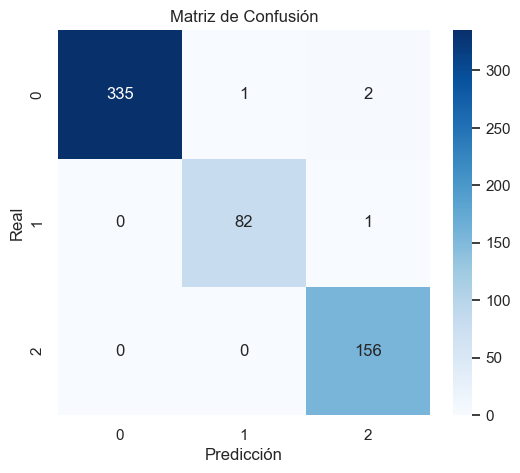

In [9]:
# Reporte de Clasificación
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones
y_pred = pipeline.predict(X_test)

# Reporte
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## 📈 Curvas ROC y AUC

Visualizamos las curvas ROC y calculamos el AUC para cada clase en un esquema One-vs-Rest.

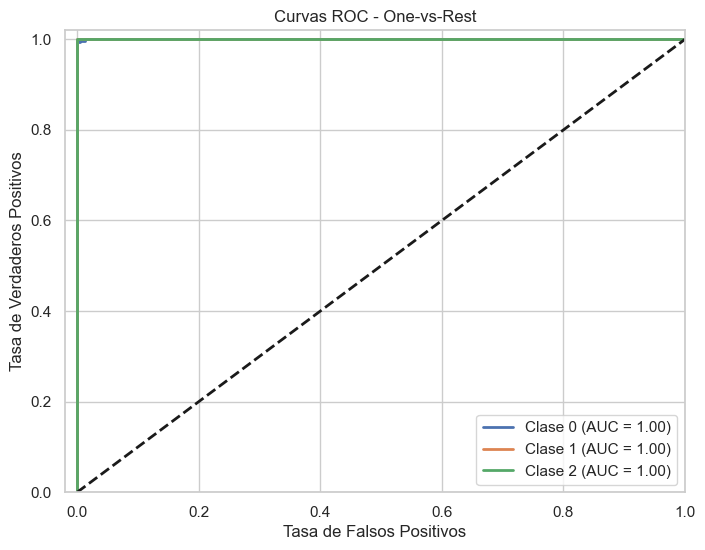

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarizar las clases
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = pipeline.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - One-vs-Rest')
plt.legend(loc="lower right")
plt.show()

## 📝 Conclusiones

A partir de las métricas obtenidas, el modelo presenta:
- Buen rendimiento en las clases mayoritarias.
- Posibles áreas de mejora en las clases minoritarias.
- AUC promedio aceptable en el conjunto de test.

Esto nos ayudará a entender cómo ajustar el modelo en futuras iteraciones.

## 💾 Guardado del Modelo

Guardamos el modelo entrenado en la carpeta `models/` para su posterior uso y despliegue.

In [12]:
import joblib
import os

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'rf_classifier_smote.pkl')
joblib.dump(pipeline, model_path)
print(f"✅ Modelo guardado exitosamente en: {model_path}")

✅ Modelo guardado exitosamente en: ../models/rf_classifier_smote.pkl


## 📊 Importancia de Variables

Analizamos la importancia relativa de las variables utilizadas por el modelo Random Forest para comprender su contribución a las predicciones.

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_88922/1189445606.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')


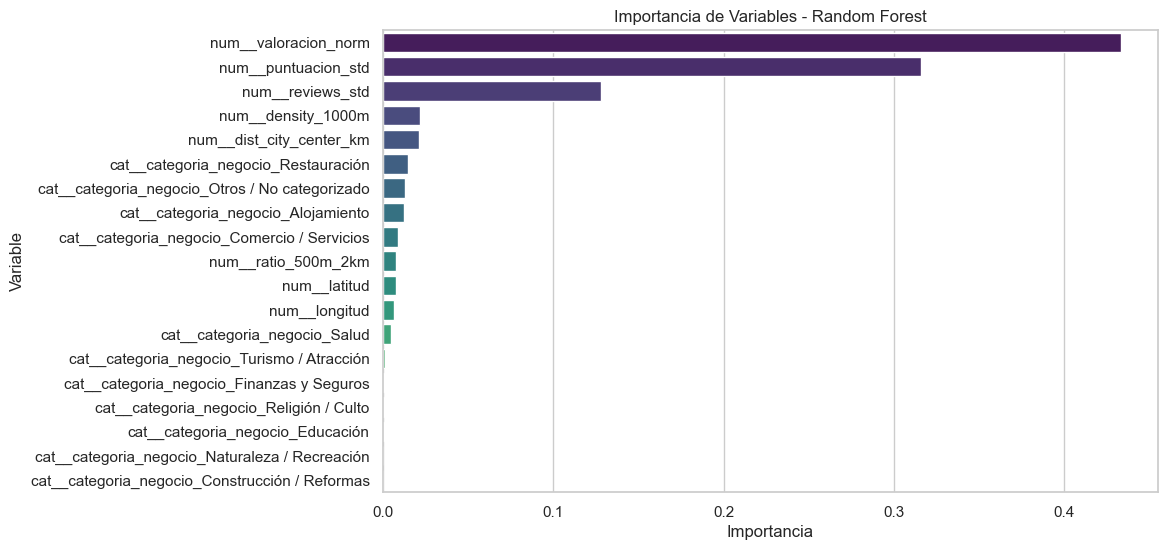

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extraer el modelo y el preprocesador del pipeline
rf_model = pipeline.named_steps['rf']
preprocessor = pipeline.named_steps['prep']

# Obtener nombres de las variables tras preprocesamiento
features = preprocessor.get_feature_names_out()

# Importancia de variables
importances = rf_model.feature_importances_

# Crear DataFrame ordenado
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualización
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

## 🎯 Visualización de la Distribución de Clases con SMOTE

En este paso visualizamos la distribución de las clases **antes** y **después** de aplicar SMOTE.  
⚠️ Importante:  
- **SMOTE debe aplicarse a datos numéricos.** Por eso, primero transformamos las variables categóricas a formato numérico mediante el preprocesador.
- **No utilizamos el resultado de SMOTE para el entrenamiento directo del modelo.** Esta celda es solo ilustrativa, ya que el pipeline se encarga automáticamente de aplicar SMOTE de forma correcta durante el entrenamiento.

Esto nos permite:
✅ Entender la distribución original de las clases.  
✅ Mostrar el efecto de SMOTE en la distribución.  
✅ Mantener la profesionalidad y la coherencia con la arquitectura del pipeline.

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_88922/1351304403.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')


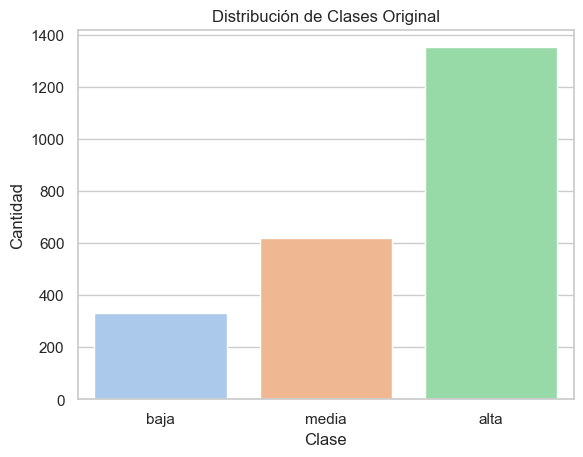

/var/folders/py/btwd7pk93f5g87hjsfgb3wmw0000gn/T/ipykernel_88922/1351304403.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette='muted')


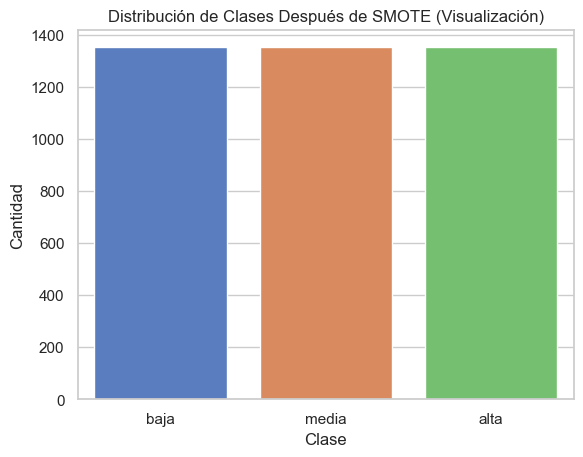

In [14]:
# Visualización de la distribución de clases antes y después de SMOTE

# Distribución de clases original
sns.countplot(x=y_train, palette='pastel')
plt.title("Distribución de Clases Original")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

# Preprocesar los datos para convertirlos a numérico
X_train_transformed = preprocessor.fit_transform(X_train)

# Aplicar SMOTE a los datos transformados (solo para visualización)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# Distribución de clases después de SMOTE (solo visualización)
sns.countplot(x=y_train_res, palette='muted')
plt.title("Distribución de Clases Después de SMOTE (Visualización)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

## 💾 Exportación de Métricas Clave

Exportamos las métricas de evaluación a un archivo CSV para documentación y análisis adicional.

In [16]:
from sklearn.metrics import classification_report

# Generar reporte
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Guardar en CSV
report_df.to_csv('../models/classification_report.csv', index=True)
print("✅ Reporte exportado a 'models/classification_report.csv'")

✅ Reporte exportado a 'models/classification_report.csv'
